This notebook is based on `starting_w_search.ipynb`, with the important innovation of incorporating physical reasoning into the designing of the starting point.

Namely, I leverage discussion points from Nov 3rd with Mikael, where we reason about $w$ given its role in the actual endpoint objective, i.e.,
\begin{equation}
    f(w) = w^T y - \psi_\alpha \lVert w \rVert_2 - b^T c.
\end{equation}

We can clearly see that $w_i$ is specifying a weight for the influence observation $y_i$ has on the final endpoint. Since there are some spatial/temporal regions which should not have any influence on the functional of interest, we should be able to set large swaths of $w$ to zero.

We use the following reasoning:
1. for observation elements that are downwind in space and time from the location of interest, an increase in the observed XCO2 value should correspond with an increase in the flux. Therefore, since higher XCO2 means more flux, $w_i > 0$.
2. for observation elements that are upwind and before the location of interest, an increase in the observed XCO2 value should correspond with a decrease in flux. Thus, $w_i < 0$.
3. for other elements, such as those in the southern hemisphere, there should be no connection between those observation and the flux of interest. Thus $w_i = 0$.

__Questions__
1. What do we do about elements over our region of interest (both spatially and temporally)?
    - my first thought is that these should also exhibit positive influence on the flux
2. As we get farther away from the space/time of interest, it is reasonable to think that we want to see a monotonic relationship on the influence. How can this be encoded?

In [1]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scipy import stats
from scipy.optimize import minimize
from tqdm.notebook import tqdm

In [2]:
BASE_DIR = '/Users/mikestanley/Research/Carbon_Flux'
BASE_DIR += '/optimization/src_admm/data/carbon_flux/objects'

# Satellite Observations and region of interest

In [3]:
# y vector
with open(BASE_DIR + '/y_affine_corrected.npy', 'rb') as f:
    y_obs = np.load(f)
    
# gosat data
with open(BASE_DIR + '/gosat_df_jan1_aug31_2010.csv', 'rb') as f:
    gosat_df = pd.read_csv(f)
L_inv_vec = 1 / gosat_df.xco2_unc.values
    
# tranform the data
y_tilde = np.multiply(L_inv_vec, y_obs)

In [4]:
# psi_alpha
with open(BASE_DIR + '/opt_res_cont.pkl', 'rb') as f:
    opt_slack = pickle.load(f)
    
PSI_ALPHA = np.sqrt(stats.chi2.ppf(q=.95, df=1) + opt_slack[1])

#### Lat/Lon Cutoffs

In [5]:
import carbonfluxtools.io_utils as cio

In [6]:
# h
with open(BASE_DIR + '/na_june_functional.npy', 'rb') as f:
    h = np.load(f)

In [7]:
# get the lon/lat for region of interest
GEO_DICT_FP = '/Users/mikestanley/Research/Carbon_Flux/data/geographic_locations.json'
geo_dict = cio.read_geo_info(file_path=GEO_DICT_FP)
lon_pts_na, lat_pts_na = cio.get_regional_info(
    geo_dict=geo_dict, region_nm='north_america'
)

In [8]:
# read in lon/lat arrays
LON_LAT_BASE = '/Users/mikestanley/Research/Carbon_Flux/data/lon_lat_arrs'
with open(LON_LAT_BASE + '/lon.npy', 'rb') as f:
    lon = np.load(f)
with open(LON_LAT_BASE + '/lat.npy', 'rb') as f:
    lat = np.load(f)

In [9]:
# define cutoffs
lon_cuts = (lon[lon_pts_na[0]], lon[lon_pts_na[-1]])
lat_cuts = (lat[lat_pts_na[0]], lat[lat_pts_na[-1]])

print(lon_cuts)
print(lat_cuts)

(-125.0, -75.0)
(30.0, 50.0)


# Create a $w$ vector

In [10]:
# below 0 latitude
below_0_lat = gosat_df['lat'] < 0

# Before june
before_jun = gosat_df['month'] < 6.0

# after june
after_jun = gosat_df['month'] > 6.0

# before -125 longitude
before_m125_lon = gosat_df['lon'] < -125.

# after -75 longtitude
after_m75_lon = gosat_df['lon'] > -75.

# below 30 latitude
below_30_lat = gosat_df['lat'] < 30.

# above 50 latitude
above_50_lat = gosat_df['lat'] > 50.

print(f'Below 0         : {below_0_lat.sum()}')
print(f'Before June     : {before_jun.sum()}')
print(f'After June      : {after_jun.sum()}')
print(f'Before -125 Lon : {before_m125_lon.sum()}')
print(f'After -75 Lon   : {after_m75_lon.sum()}')
print(f'Below 30 Lat    : {below_30_lat.sum()}')
print(f'Above 50 Lat    : {above_50_lat.sum()}')

Below 0         : 10527
Before June     : 16048
After June      : 8234
Before -125 Lon : 2702
After -75 Lon   : 20954
Below 30 Lat    : 18672
Above 50 Lat    : 3625


In [11]:
# boolean masks
# upwind and before june
upwind_before_june = before_m125_lon * before_jun

# downwind and after june
downwind_after_june = after_m75_lon * after_jun

In [12]:
# making constraint matrices
# A := southern hemisphere elements are 0
# B := upwind and before june are negative
# C := downwind and after june are positive
d_A = below_0_lat.sum()
d_B = upwind_before_june.sum()
d_C = downwind_after_june.sum()

In [13]:
# make the arrays
A = np.diag(below_0_lat).astype(np.float32)
A_zero = A.sum(axis=1) == 0.
A = np.delete(A, A_zero, axis=0)

B = np.diag(upwind_before_june).astype(np.float32)
B_zero = B.sum(axis=1) == 0.
B = np.delete(B, B_zero, axis=0)

C = np.diag(downwind_after_june).astype(np.float32)
C_zero = C.sum(axis=1) == 0.
C = np.delete(C, C_zero, axis=0)

print(A.shape)
print(B.shape)
print(C.shape)

(10527, 28267)
(1432, 28267)
(6145, 28267)


# Starting point generation WITHOUT optimization

Namely, we just want to find a starting point respecting
1. Zero below the 0 latitude line
2. Negative upwind and before the region/time of interest
3. Positive downwind and after the region/time of interest

In [17]:
def lep_obj(w):
    """ Assumes c == 0 """
    return np.dot(y_tilde, w) - PSI_ALPHA * np.linalg.norm(w)

In [29]:
# constant to use for non-zero elements
const = .00001

# initialize vector
w_start = np.ones_like(y_tilde)

# zero out the southern hemisphere
w_start[below_0_lat.values] = 0.

# upwind (negative)
w_start[upwind_before_june.values] = -1.

# downwind (positive)
w_start[downwind_after_june.values] = 1.

# final scaling
w_start *= const

In [30]:
# what is the endpoint value at this point?
lep_obj(w_start)

-0.36370585692292423

In [31]:
# add start to the observation dataframe
gosat_df['w_start'] = w_start.copy()

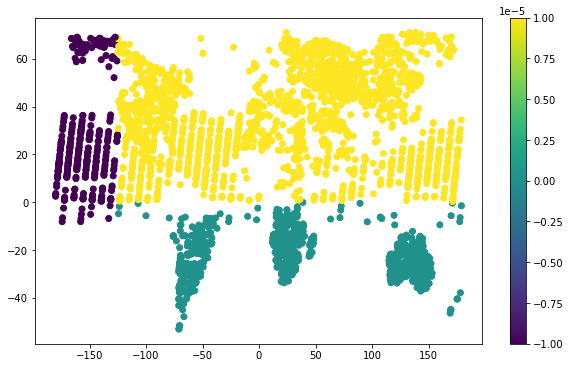

In [33]:
MONTH_IDXS = gosat_df['month'] == 5
plt.figure(figsize=(10, 6))
plt.scatter(gosat_df['lon'][MONTH_IDXS], gosat_df['lat'][MONTH_IDXS], c=w_start[MONTH_IDXS])
plt.colorbar()
plt.show()

### Save the above objects

In [35]:
SAVE_BASE = '/Users/mikestanley/Research/Carbon_Flux/optimization/src_admm/data/carbon_flux/results'

In [36]:
# read in previous output to get c and lambda dimensions correct
with open(SAVE_BASE + '/02/opt_output_04.pkl', 'rb') as f:
    res_dict_04 = pickle.load(f)

In [42]:
# output vectors
with open(SAVE_BASE + '/04/intermediate_starts/w_start_it0.npy', 'wb') as f:
    np.save(file=f, arr=w_start)

with open(SAVE_BASE + '/04/intermediate_starts/c_start_it0.npy', 'wb') as f:
    np.save(file=f, arr=np.zeros(res_dict_04['c_opt_vecs'].shape[1]))

with open(SAVE_BASE + '/04/intermediate_starts/lambda_start_it0.npy', 'wb') as f:
    np.save(file=f, arr=np.zeros(res_dict_04['lambda_opt_vecs'].shape[1]))

### Optimize the objective with the above constraints

In [58]:
# create bound constraints
bounds_list = [(None, None)]* y_tilde.shape[0]
for i in range(y_tilde.shape[0]):
    if upwind_before_june.iloc[i]:
        bounds_list[i] = (None, 0.0)
    elif downwind_after_june.iloc[i]:
        bounds_list[i] = (0.0, None)
    if below_0_lat.iloc[i]:
        bounds_list[i] = (0.0, 0.0)

In [63]:
def south_hem_con(x, A=A):
    return A @ x

def upwind_con(x, B=B):
    return -B @ x

def downwind_con(x, C=C):
    return C @ x

# constraint list
cons = [
    {'type': 'eq', 'fun': south_hem_con},
    {'type': 'ineq', 'fun': upwind_con},
    {'type': 'ineq', 'fun': downwind_con},
]

# define objective and gradient
def obj(x, y=y_tilde):
    """ Assumes c == 0 """
    return - np.dot(x, y) + PSI_ALPHA * np.linalg.norm(x)

def obj_grad(x, y=y_tilde):
    """ Assumes c == 0 """
    return -y + PSI_ALPHA * (x / np.linalg.norm(x))

In [ ]:
# optimize
np.random.seed(42)
x0_gauss = stats.norm.rvs(size=y_tilde.shape[0])
t = 10.  # hyperparamter for l2 constraint
res = minimize(
    fun=obj,
    x0=x0_gauss,
    method='trust-constr',
    jac=obj_grad,
    constraints=[{'type': 'ineq', 'fun': lambda x: t - np.linalg.norm(x)}],
    bounds=bounds_list,
    options={'verbose': 2}
)